In [1]:
%matplotlib inline
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from inforet_package.preprocessing import *
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
tqdm.pandas()

Populating the interactive namespace from numpy and matplotlib


In [2]:
#loading data
df = pd.read_csv("../data/train.csv")

In [3]:
def print_datasets_info(df):
    print("{} rows loaded...".format(df.shape[0]))
    print("columns are: {}".format(list(df.columns)))
    print("{0:.2f}% of sincere questions".format(len(df[df['target'] == 0])*100/df.shape[0]))
    print("{0:.2f}% of insincere questions".format(len(df[df['target'] == 1])*100/df.shape[0]))

#reducted_df = df.sample(frac=0.2)
reducted_df = df
print_datasets_info(reducted_df)

1306122 rows loaded...
columns are: ['qid', 'question_text', 'target']
93.81% of sincere questions
6.19% of insincere questions


In [4]:
reducted_df['double'] = reducted_df['question_text'].progress_apply(lambda x: sentiment_pattern(x))

In [5]:
reducted_df['polarity'] = [d[0] for d in tqdm(reducted_df.double)]
reducted_df['subjectivity'] = [d[1] for d in tqdm(reducted_df.double)]
reducted_df = reducted_df.drop('double', 1)

In [6]:
reducted_df['double'] = reducted_df['question_text'].progress_apply(lambda x: get_modality_mood(x))

In [7]:
reducted_df['modality'] = [d[0] for d in tqdm(reducted_df.double)]
reducted_df['mood'] = [d[1] for d in tqdm(reducted_df.double)]
reducted_df = reducted_df.drop('double', 1)

In [8]:
questions = cleaning_questions(reducted_df)
tfidf_vocab, TfIdfMatrix, idf_dict = idf_dictionary_builder(questions)
reducted_df['cleaned_questions'] = clean_stopwords(questions, idf_dict, 4)

insincere_df = reducted_df[reducted_df['target'] == 1]
vocab_dictionary = build_dictionary(reducted_df['cleaned_questions'])
insincere_vocab_dictionary = build_dictionary(insincere_df['cleaned_questions'])

spec_dict = get_specificity(vocab_dictionary, insincere_vocab_dictionary)
reducted_df['specificity_average'] = reducted_df['cleaned_questions'].progress_apply(lambda x: specificity_average(x, spec_dict))

In [9]:
sincere_questions = reducted_df[reducted_df['target'] == 0]
insincere_questions = reducted_df[reducted_df['target'] == 1]

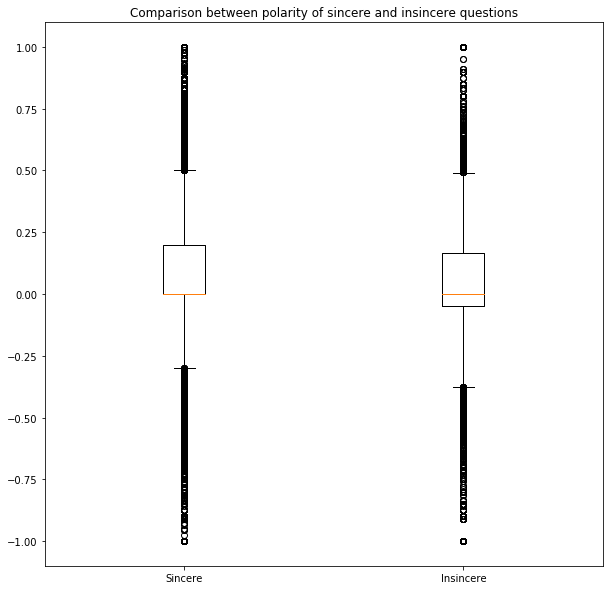

0.0
0.0


In [10]:
def boxplot_print(df_sincere, df_insincere, column):
    fig = plt.figure(1, figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.boxplot([df_sincere[column], df_insincere[column]])
    ax.set_xticklabels(['Sincere', 'Insincere'])
    ax.set_title('Comparison between {} of sincere and insincere questions'.format(column))
    plt.show()

boxplot_print(sincere_questions, insincere_questions, 'polarity')
print(sincere_questions['polarity'].median())
print(insincere_questions['polarity'].median())

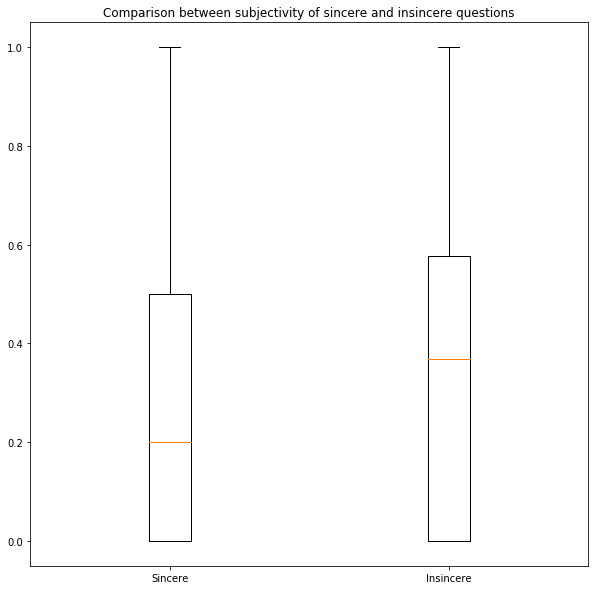

0.2
0.3676587301587302


In [11]:
boxplot_print(sincere_questions, insincere_questions, 'subjectivity')
print(sincere_questions['subjectivity'].median())
print(insincere_questions['subjectivity'].median())

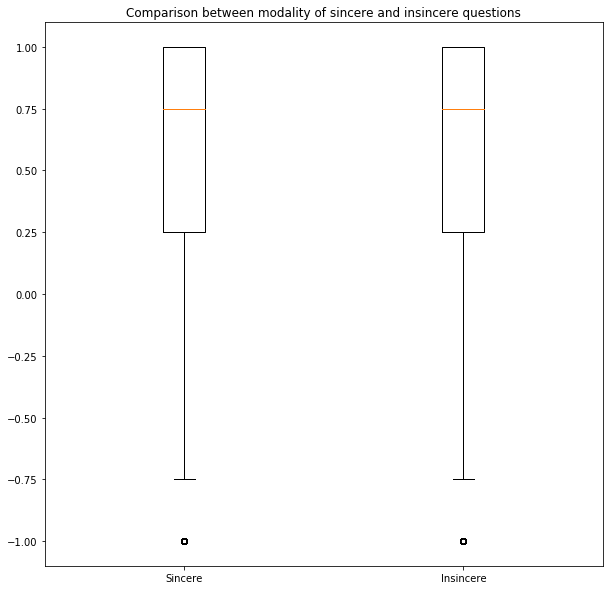

0.75
0.75


In [12]:
boxplot_print(sincere_questions, insincere_questions, 'modality')
print(sincere_questions['modality'].median())
print(insincere_questions['modality'].median())

In [17]:
sincere_size = sincere_questions.shape[0]
sincere_perc = sincere_questions.groupby(['mood']).size().apply(lambda x: (x/sincere_size)*100)

insincere_size = insincere_questions.shape[0]
insincere_perc = insincere_questions.groupby(['mood']).size().apply(lambda x: (x/insincere_size)*100)

print(sincere_perc)
print(insincere_perc)

mood
conditional     0.495058
imperative      0.292905
indicative     99.198163
subjunctive     0.013874
dtype: float64
mood
conditional     1.041950
imperative      1.286969
indicative     97.636431
subjunctive     0.034649
dtype: float64


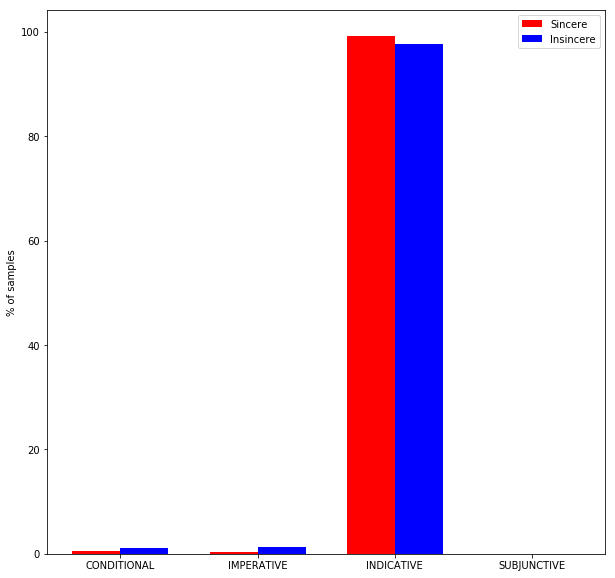

In [16]:
def print_bar_chart(sincere_percentage, insincere_percentage):
    l_sinc = len(sincere_percentage)
    l_insinc = len(insincere_percentage)
    assert l_sinc == l_insinc
    fig = plt.figure(1, figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    ind = np.arange(l_sinc)
    width = 0.35
    rects1 = ax.bar(ind, sincere_percentage, width, color='r')
    rects2 = ax.bar(ind + width, insincere_percentage, width, color='b')
    ax.set_ylabel('% of samples')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('CONDITIONAL', 'IMPERATIVE', 'INDICATIVE', 'SUBJUNCTIVE'))

    ax.legend((rects1[0], rects2[0]), ('Sincere', 'Insincere'))
    plt.show()

print_bar_chart(sincere_perc.tolist(), insincere_perc.tolist())

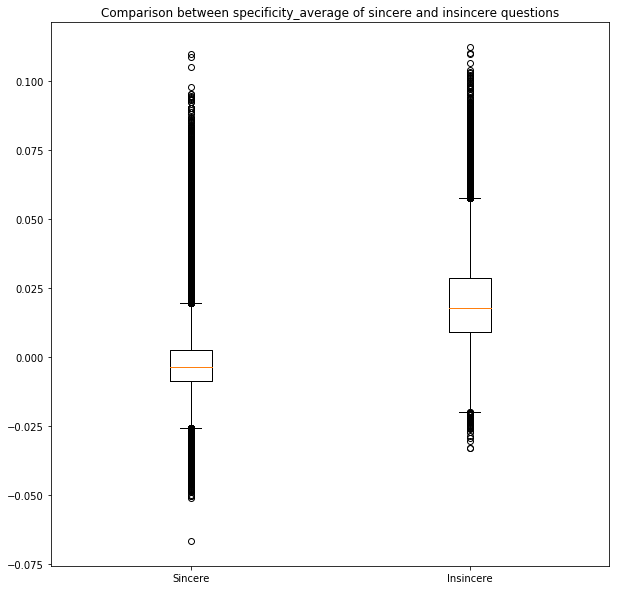

In [15]:
boxplot_print(sincere_questions, insincere_questions, 'specificity_average')